In [18]:
#import library we need
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
#link uploaded Data set
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#Loading ratings & movies
ratings_data = pd.read_csv('drive/My Drive/Colab Notebooks/ratings.dat', sep='::', header=None,engine='python')
movies_data = pd.read_csv('drive/My Drive/Colab Notebooks/movies.dat', sep='::', header=None, engine='python',encoding='latin-1')

In [21]:
#Add column names
movies_data.columns = ['MovieID', 'Title', 'Genres']
ratings_data.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies_data['List Index'] = movies_data.index

In [22]:
#plot head of movie
movies_data.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [23]:
#plot head of rating
ratings_data.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [24]:
#plot tail of movie
movies_data.tail()
#so we need to add index

,MovieID,Title,Genres,List Index
3878,3948,Meet the Parents (2000),Comedy,3878
3879,3949,Requiem for a Dream (2000),Drama,3879
3880,3950,Tigerland (2000),Drama,3880
3881,3951,Two Family House (2000),Drama,3881
3882,3952,"Contender, The (2000)",Drama|Thriller,3882


In [25]:
#merge ratings & movies
#delete unnecessary columns 
merged_data = movies_data.merge(ratings_data, on='MovieID')
merged_data = merged_data.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
userGroup = merged_data.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [26]:
#Creating the training list
amountOfUsedUsers = 1000
train_X = []
for userID, curUser in userGroup:
    temp = [0]*len(movies_data)
    for num, movie in curUser.iterrows():
        temp[movie['List Index']] = movie['Rating']/5.0
    train_X.append(temp)
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

In [27]:
#build RBM network using tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
hiddenUnits = 20 
visibleUnits = len(movies_data)
vb = tf.placeholder("float", [visibleUnits]) 
hb = tf.placeholder("float", [hiddenUnits]) 
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [28]:
#defining activation functions
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb) 

In [29]:
#Setting RBM training parameters and functions.
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)
#Set MAE for error function
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [30]:
#Initalize variables using zero values
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
cur_vb = np.zeros([visibleUnits], np.float32)
cur_hb = np.zeros([hiddenUnits], np.float32)
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
prv_vb = np.zeros([visibleUnits], np.float32)
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.19043313
0.12393828
0.09666017
0.08286798
0.074260116
0.06826055
0.063525036
0.06035905
0.0571976
0.053144272
0.04978508
0.047879953
0.046541292
0.04550622
0.044697504
0.044190977
0.043702725
0.043520108
0.043086752
0.042834267


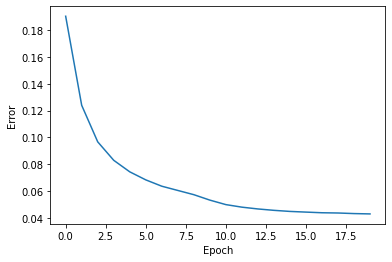

In [31]:
#Train Network
epochs = 20
batchsize = 200
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(train_X), batchsize), range(batchsize, len(train_X), batchsize)):
        batch = train_X[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: train_X, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [33]:
#Recommendation part, e.g. user number 75
inputUser = [train_X[85]]
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

scored_movies_df_85 = movies_data
scored_movies_df_85["Recommendation Score"] = rec[0] 
scored_movies_df_85.sort_values(["Recommendation Score"], ascending=False).head(20)

merged_data.iloc[85]
movies_data_85 = merged_data[merged_data['UserID']==215]
movies_data_85.head() 

merged_data_85 = scored_movies_df_85.merge(movies_data_85, on='MovieID', how='outer')
merged_data_85 = merged_data_85.drop('List Index_y', axis=1).drop('UserID', axis=1)

#NaN ratings are the ones which user has not seen yet.

merged_data_85.sort_values(["Recommendation Score"], ascending=False).head(20)

#special thanks to https://www.kaggle.com/code/amitmeel1/restricted-bolztmann-machine-rbm

,MovieID,Title,Genres,List Index_x,Recommendation Score,Rating
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,257,0.533439,5.0
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.462113,NaN
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.459034,NaN
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2502,0.398719,NaN
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.383138,4.0
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,476,0.368066,5.0
2928,2997,Being John Malkovich (1999),Comedy,2928,0.366176,NaN
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1178,0.365692,NaN
523,527,Schindler's List (1993),Drama|War,523,0.349825,NaN
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.345180,NaN
